# Fixed Synthetic Results Plotting
## Box/Violin Plots Instead of Line Plots

This notebook creates proper visualizations for synthetic experiment results using Box and Violin plots, which are more appropriate for independent iterations than line plots.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from pathlib import Path

# Set style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries loaded successfully!")


Libraries loaded successfully!


In [3]:
# Load the fixed results
results_file = "../results/synthetic_debug/phase3_all_methods_results.csv"

if Path(results_file).exists():
    df = pd.read_csv(results_file)
    print(f"Loaded {len(df)} results from {results_file}")
    print(f"Methods: {df['model_name'].unique()}")
    print(f"Scenarios: {df['scenario'].unique()}")
    print(f"Columns: {list(df.columns)}")
else:
    print(f"Results file not found: {results_file}")
    print("Please run the Phase 3 experiment first.")


Loaded 60 results from ../results/synthetic_debug/phase3_all_methods_results.csv
Methods: ['lasso' 'RandomForest' 'NeuralNet']
Scenarios: ['A' 'B']
Columns: ['model_name', 'iteration', 'seed_iter', 'best_f1', 'best_threshold', 'f1_val', 'accuracy', 'precision', 'recall', 'tp', 'fp', 'fn', 'tn', 'y_pred', 'y_prob', 'selected_features', 'method_has_selection', 'n_selected', 'n_nonzero', 'lasso_C', 'lasso_coefs', 'coef_hash', 'train_samples', 'val_samples', 'test_samples', 'scenario', 'scenario_description', 'dataset_hash', 'test_hash', 'true_support', 'n_true_features', 'beta_true', 'feature_importances', 'importance_hash', 'best_params', 'weights_hash']


In [4]:
# Data preparation
if 'df' in locals():
    # Filter out any error results
    if 'error' in df.columns:
        df_clean = df[df['error'].isna()].copy()
        print(f"Filtered to {len(df_clean)} successful results")
    else:
        df_clean = df.copy()
    
    # Ensure numeric columns
    numeric_cols = ['best_f1', 'accuracy', 'precision', 'recall', 'n_selected']
    for col in numeric_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    print("\nData Summary:")
    print(df_clean.groupby(['scenario', 'model_name']).agg({
        'best_f1': ['count', 'mean', 'std'],
        'accuracy': 'mean'
    }).round(4))



Data Summary:
                      best_f1                 accuracy
                        count    mean     std     mean
scenario model_name                                   
A        NeuralNet         10  0.5792  0.0629   0.5739
         RandomForest      10  0.5713  0.0607   0.5626
         lasso             10  0.5760  0.0661   0.5671
B        NeuralNet         10  0.5401  0.0632   0.5244
         RandomForest      10  0.5483  0.0504   0.5254
         lasso             10  0.5272  0.0550   0.5280


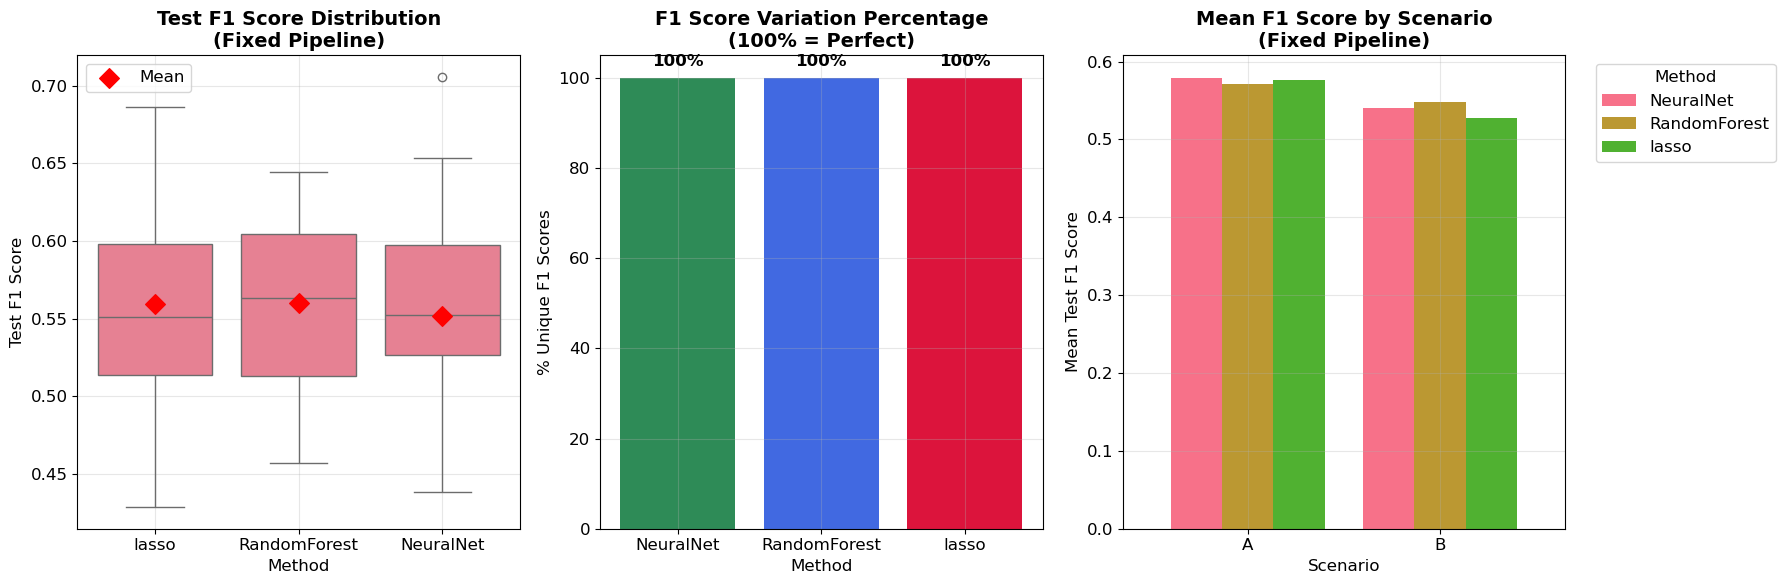


Variation Analysis Summary:
lasso:
  Unique F1 scores: 20/20 (100.0%)
  Standard deviation: 0.0643
  Range: 0.2577
  Min: 0.4285, Max: 0.6862

RandomForest:
  Unique F1 scores: 20/20 (100.0%)
  Standard deviation: 0.0556
  Range: 0.1877
  Min: 0.4569, Max: 0.6446

NeuralNet:
  Unique F1 scores: 20/20 (100.0%)
  Standard deviation: 0.0646
  Range: 0.2673
  Min: 0.4385, Max: 0.7058



In [5]:
# Create final summary plot for report
if 'df_clean' in locals():
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot 1: Box plot of F1 scores
    sns.boxplot(data=df_clean, x='model_name', y='best_f1', ax=axes[0])
    axes[0].set_title('Test F1 Score Distribution\n(Fixed Pipeline)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Method')
    axes[0].set_ylabel('Test F1 Score')
    axes[0].grid(True, alpha=0.3)
    
    # Add mean diamonds
    means = df_clean.groupby('model_name')['best_f1'].mean()
    for i, method in enumerate(means.index):
        axes[0].scatter(i, means[method], marker='D', s=100, color='red', zorder=10, label='Mean' if i == 0 else "")
    if len(means) > 0:
        axes[0].legend()
    
    # Plot 2: Variation percentage
    unique_counts = df_clean.groupby('model_name')['best_f1'].nunique()
    total_counts = df_clean.groupby('model_name').size()
    variation_pct = (unique_counts / total_counts * 100)
    
    bars = axes[1].bar(variation_pct.index, variation_pct.values, color=['#2E8B57', '#4169E1', '#DC143C'])
    axes[1].set_title('F1 Score Variation Percentage\n(100% = Perfect)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Method')
    axes[1].set_ylabel('% Unique F1 Scores')
    axes[1].set_ylim(0, 105)
    axes[1].grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for bar, pct in zip(bars, variation_pct.values):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                    f'{pct:.0f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # Plot 3: F1 by scenario
    scenario_means = df_clean.groupby(['scenario', 'model_name'])['best_f1'].mean().unstack()
    scenario_means.plot(kind='bar', ax=axes[2], width=0.8)
    axes[2].set_title('Mean F1 Score by Scenario\n(Fixed Pipeline)', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Scenario')
    axes[2].set_ylabel('Mean Test F1 Score')
    axes[2].legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[2].grid(True, alpha=0.3)
    axes[2].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Print variation analysis
    print("\nVariation Analysis Summary:")
    print("=" * 50)
    for method in df_clean['model_name'].unique():
        method_data = df_clean[df_clean['model_name'] == method]['best_f1']
        unique_count = method_data.nunique()
        total_count = len(method_data)
        variation_pct = unique_count / total_count * 100
        
        print(f"{method}:")
        print(f"  Unique F1 scores: {unique_count}/{total_count} ({variation_pct:.1f}%)")
        print(f"  Standard deviation: {method_data.std():.4f}")
        print(f"  Range: {method_data.max() - method_data.min():.4f}")
        print(f"  Min: {method_data.min():.4f}, Max: {method_data.max():.4f}")
        print()
